In [2]:
import os
import pandas as pd
import numpy as np
import torch
from datetime import datetime, timedelta

from tqdm import tqdm
from src.datasets import ContentWise, RL4RS, OpenCDP
from src.utils import get_train_val_test_tmatrix_tnumitems

pkl_path = '../pkl/'
data_path = '../data/recsys/'

# ContentWise

In [2]:
c_path = os.path.join( data_path, 'ContentWiseImpressions/data/ContentWiseImpressions/CW10M-CSV/')

c = ContentWise(c_path, min_session_len=3, max_session_len=100)
c.dump(os.path.join(pkl_path, 'cw.pkl'))

reading files. . . 
preprocessing. . . 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 329870/329870 [00:10<00:00, 30628.89it/s]


biulding affinity matrix...


272907it [01:49, 2498.53it/s]


### Self-check

In [ ]:
BATCH_NO = 0

# loading pickled dataset, gettin data loaders
c = ContentWise.load(os.path.join(pkl_path, 'cw.pkl'))
( 
    c_train_loader, 
    c_val_loader, 
    c_test_loader, 
    c_train_user_item_matrix, 
    train_num_items,
) = get_train_val_test_tmatrix_tnumitems(c, batch_size=2, seed=123)

# get batch from test loader
i = 0
for batch in c_test_loader:
    if i < BATCH_NO:
        i += 1
        continue
    break

for key, value in batch.items():
    print(f'\n == {key} ==')
    print(value)

# get users
user_id = batch['user_ids'][0][0].item(), batch['user_ids'][1][0].item()
user_idx = batch['user_indexes'][0][0].item(), batch['user_indexes'][1][0].item()



In [ ]:
# response counts user 1: carefully check manually
for i, user in enumerate(user_idx):
    print(f'\nuser {user}\n')
    print(c_train_user_item_matrix[user, :])
    items = batch['slates_item_indexes'][i][batch['responses'][i] > 0]
    counts = batch['responses'][i][batch['responses'][i] > 0]
    print(torch.stack([items, counts]).T)

# batches are collated OK

In [ ]:
# checking dataset: search random user
USER_ID = 1223
DATA_POINT = -1
for i, user in enumerate(c):
    if user['user_ids'][0]==USER_ID:
        DATA_POINT = i
c[DATA_POINT]['slates_item_ids'], c[DATA_POINT]['responses']

In [ ]:
# manually compare with tables
ratings = pd.read_csv(
    os.path.join(c_path, 'interactions.csv.gz'), 
    compression='gzip', 
    delimiter=','
)
ratings[(ratings.user_id == USER_ID) & (ratings.recommendation_id != -1)].sort_values('utc_ts_milliseconds')

In [ ]:
c.metadata[c.metadata['user_id'] == USER_ID]

In [ ]:
c.responses[c.metadata[c.metadata['user_id'] == USER_ID].index]

In [ ]:
slates_log = pd.read_csv(
    os.path.join(c_path, 'impressions-direct-link.csv.gz'),
    compression='gzip', 
    delimiter=','
)

In [ ]:
recommendations = ratings[(ratings.user_id == USER_ID) & (ratings.recommendation_id != -1)].recommendation_id.unique()
slates_log[slates_log.recommendation_id.isin(recommendations)]

# RL4RS

In [4]:
r_path = os.path.join(data_path, 'rl4rs-dataset/')
r = RL4RS(
    r_path,
    which='rl4rs_dataset_b_sl.csv', 
    min_session_len=3
)
r.dump(os.path.join(pkl_path, 'rl4rs.pkl'))

reading files ...
preprocessing ...
preprocessing done
biulding affinity matrix...


147368it [00:51, 2880.53it/s]


In [ ]:
r = RL4RS.load(os.path.join(pkl_path, 'rl4rs.pkl'))
DATA_POINT = 1234
session = r[DATA_POINT]['session']
for key, value in r[DATA_POINT].items():    
    print(f'\n == {key} ==')
    print(value)


In [ ]:
df = pd.read_csv(
    os.path.join(r_path,'rl4rs_dataset_b_sl.csv'),
    delimiter='@'
)
df[df['session_id'] == session ]

 # OpenCDP

In [16]:
cosmetics_path = os.path.join(data_path, 'OpenCDP/cosmetics')
w_size = 8
a_hrs = 24

o = OpenCDP(
    cosmetics_path, 
    min_session_len=3 * w_size, # early crop sessions with < 3 user-recsys iteractions
    window_size=w_size, 
    max_active_hours=a_hrs,
)
o.dump(os.path.join(pkl_path, f'cosmetics_{w_size}_{a_hrs}.pkl'))

reading files...
total 20692840 raw events
after filtering total 7996737 events


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127785/127785 [11:47<00:00, 180.59it/s]


biulding affinity matrix...


488467it [02:27, 3319.78it/s]


### It is too large to handle it simultaneously -- using only first month

In [ ]:
multi_path = os.path.join(data_path, 'OpenCDP/multi') 
for w_size in [5, 10, 20]:
    for a_hrs in [1, 2, 4, 8, 24]:
        o = OpenCDP(
            multi_path,
            files = ['2019-Dec.csv'],
            min_session_len=3 * w_size, # early crop sessions with < 3 user-recsys iteractions
            window_size=w_size, 
            max_active_hours=a_hrs,
        )
        o.dump(os.path.join(pkl_path, f'multi_{w_size}_{a_hrs}.pkl'))

In [2]:
data_dir = os.path.join(data_path, 'OpenCDP/cosmetics')
files = None 

files = os.listdir(data_dir) if files is None else files
events = [pd.read_csv(os.path.join(data_dir, file)) for file in files]
raw_events = pd.concat(events)

# there are separate sessions for single user,
raw_events.user_id.count(), raw_events.user_session.count()

(20692840, 20688242)

In [3]:
raw_events.event_type.value_counts()

event_type
view                9657821
cart                5768333
remove_from_cart    3979679
purchase            1287007
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

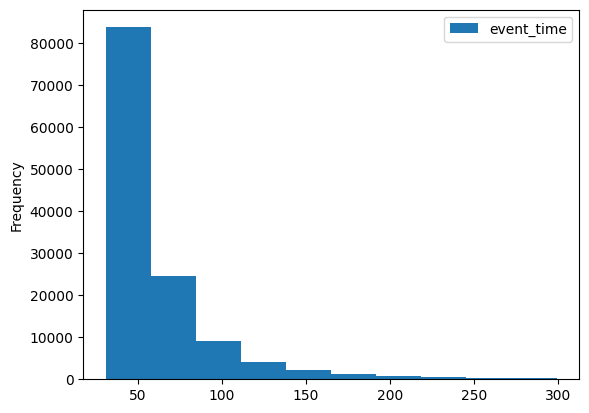

In [4]:
# чтобы собрать хоть какие-то выдачи, нам надо хотя-бы несколько десятков событий для каждого юзера
c = raw_events[["user_session","event_time"]].groupby('user_session').count()
c[(c.event_time < 300) & (c.event_time > 30)].plot.hist()

In [5]:
# практически все сессии из одного взаимодействия, придется их дропнуть. 
MIN_SESSION_LEN = 30
good_sessions = c[c.event_time > 30].index
print(len(good_sessions))
raw_events = raw_events[raw_events.user_session.isin(good_sessions)]
raw_events.head()

127785


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
3,2020-01-01 00:00:24 UTC,view,5793052,1487580005754995573,NaN,NaN,4.92,420652863,546f6af3-a517-4752-a98b-80c4c5860711
8,2020-01-01 00:00:57 UTC,view,5726464,1487580005268456287,NaN,NaN,5.56,420652863,546f6af3-a517-4752-a98b-80c4c5860711
11,2020-01-01 00:01:05 UTC,view,5809910,1602943681873052386,NaN,grattol,5.24,588166646,e099adca-fec5-4aef-820f-6116836e322a
17,2020-01-01 00:01:37 UTC,view,5741344,1487580005427839846,NaN,irisk,4.29,420652863,546f6af3-a517-4752-a98b-80c4c5860711
20,2020-01-01 00:01:40 UTC,view,5784983,2195085255034011676,NaN,severina,2.06,502631750,6edb4c0e-285c-4fbc-8977-589ef6d326b8


In [6]:
# cart > view wtf?
raw_events.event_type.value_counts()

event_type
cart                2645541
remove_from_cart    2450163
view                2236518
purchase             664515
Name: count, dtype: int64

**Из чата:**
1. Берем в качестве "рекомендаций" просмотры, а в качестве "отклика"— добавления в корзину. Конверсия из корзины в покупки — тоже можно, но звучит гораздо менее естественно, основной вариант первый.

2. Объединяем наши "рекомендации" в выдачи двумя вариантами:
* либо по дням, типа **"выдача" —  это все просмотренные за день товары**
* либо окном фиксированно длины. **"выдача" — это последние M просмтренных айтемов**
* либо (подумал уже после обсуждения) объединяя оба варианта, то есть "выдачей" считаются те айтемы, которые просмотрены не слишком много времени назад, и при этом не слишком много айтемов назад

3. Пробуем все варианты, играем размером окна/периодом/etc, смотрим при каком получаются самые адекватные размеры "выдач" и "сессий"

Все это, конечно, в каком-то смысле манипуляция данными, но на безрыбье (при отсутсвии других датасетов с явно залогированными выдачами), выбирать не приходится. Заняться этим планируется уже после формального дедлайна, так как у нас есть два датасета с явными выдачами, и мы считаем метрики на них. Потом просто добавится чисел на новых данных.

In [7]:
from collections import Counter, OrderedDict

class Indexer:
    """
        Index <--> Id register
        default index: 0
    """
    def __init__(self, default_token=None):
        self.default_token = default_token
        self.index2id = [ default_token ]
        self.id2index = {default_token:0}
        self.counter = Counter()
            
    def update(self, value):
        if value in self.id2index:
            return self.id2index[value]
        else:
            idx = len(self.index2id)
            self.index2id.append(value)
            self.id2index[value] = idx
            return idx
    
    def get(self, value):
        if value not in self.id2index:
            return 0
        return self.id2index[value]

    def from_iter(self, column, min_occurences=5):
        counter = self.counter.update(column)
        frequent = {
            id for id in self.counter if self.counter[id] > min_occurences
        }
        frequent.discard(self.default_token)
        self.index2id = [ self.default_token ] + list(frequent)
        self.id2index = { id:index for (index, id) in enumerate(self.index2id) }
        return self

brand_indexer = Indexer(np.nan).from_iter(raw_events.brand)
# brand_indexer.index2id

In [8]:
# counter = Counter()
# counter

In [9]:
# фиксированное окно из k предметов
WINDOW_SIZE = 8
# число часов, в течение которых клики понимаются как отдельная "выдача"
ACTIVE_HOURS = 24

recommendations = []
responses = []
metadata = []
category_features = []

brand_indexer = Indexer(np.nan).from_iter(raw_events.brand)
cat_indexer = Indexer(np.nan).from_iter(raw_events.category_code)

idx = 0   

for session, group in tqdm(raw_events.groupby('user_session')):
    rec = []
    cat_features = []
    clicks = []
    for timestamp, row in group.sort_values(by='event_time').iterrows():
        if row.event_type == 'remove_from_cart' or row.event_type == 'purchase':
            continue
        
        # сохраняем время первого взаимодействия в "выдаче"
        if len(rec) == 0:
            first_action = datetime.strptime(row.event_time, "%Y-%m-%d %H:%M:%S UTC")
        # добавляем событие просмотра /  корзины
        if row.event_type == 'cart':
            if row.product_id not in rec:
                rec.append(row.product_id)
                cat_features.append(
                    [
                        cat_indexer.get(row.category_code), 
                        brand_indexer.get(row.brand)
                    ]
                )
                clicks.append(1)
            else:
                clicks[rec.index(row.product_id)] += 1
        elif row.event_type == 'view':
            rec.append(row.product_id)
            cat_features.append(
                [
                    cat_indexer.get(row.category_code), 
                    brand_indexer.get(row.brand)
                ]
            )
            clicks.append(0)
        else:
            raise ValueError

        # ecли прошло слишком много времени внутри выдачи, закончим ее
        if (datetime.strptime(row.event_time, "%Y-%m-%d %H:%M:%S UTC") -
                first_action >
                timedelta(hours=ACTIVE_HOURS)):
            rec.extend([-1] * (WINDOW_SIZE - len(rec)))
            clicks.extend([0] * (WINDOW_SIZE - len(clicks)))
            cat_features.extend(
                [[0, 0]] * (WINDOW_SIZE - len(cat_features))
            )
            
        if len(rec) == WINDOW_SIZE:
            metadata.append({
                'recommendation_idx': len(recommendations),
                'item_feature_idx': len(recommendations),
                'session_id': row.user_session,
                'user_id': row.user_id,
                'timestamp': row.event_time,
            })
            recommendations.append(rec)
            responses.append(clicks)
            category_features.append(cat_features)
            rec, clicks, cat_features = [], [], []
    # break

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127785/127785 [12:59<00:00, 163.99it/s]


In [13]:
for m in metadata:
    m['item_feature_idx'] = m['item_features_idx']

In [14]:
from src.datasets import RecommendationData
r = RecommendationData(
            recommendations = np.array(recommendations).astype(int),
            responses = np.array(responses).astype(int),
            metadata = pd.DataFrame(metadata),
            item_categorical = np.array(category_features).astype(int),
        )


biulding affinity matrix...


488467it [02:27, 3307.43it/s]


In [15]:
r.dump(os.path.join(pkl_path, 'cosmetics_8_24.pkl'))

In [ ]:
df = pd.DataFrame(metadata)
df

In [ ]:
for i in range(len(r)):
    if -1 in r[i]['slates_item_ids']:
        break
r[i]
    

In [ ]:
raw_events[(raw_events.user_session == '0002dda7-653c-44b3-be14-ff8857e90f1f')].sort_values('event_time').head(50)

# Generated Dataset statistics

In [ ]:
res = {}

for filename in os.listdir('../pkl'):
    if not (
        # filename.startswith('multi') or\
        filename.startswith('cosmetics')
    ):
        continue
    o = OpenCDP.load(
        os.path.join('../pkl/', filename),
    )
    o.metadata.set_index(['session_id', 'timestamp'], drop=False, inplace=True)
    o.metadata.sort_index(inplace=True)
    o.dump(os.path.join('../pkl/', filename))
    N = len(o)
    stats = {
        'length': 0,
        'real_slate_size': 0        
    }
    for datapoint in tqdm(o, desc=filename):
        stats['length'] += datapoint['length']
        stats['real_slate_size'] += datapoint['slates_mask'].sum()
    stats['real_slate_size'] /= stats['length']
    stats['length'] /= N
    res[filename] = stats
res